In [ ]:
# Load packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
pip install lifelines

In [ ]:
# Read datasets needed
from google.colab import files 
uploaded = files.upload()

Saving 0817_optimal_target.csv to 0817_optimal_target.csv
Saving 0817_X_imputed.csv to 0817_X_imputed.csv


In [ ]:
import io
feature = pd.read_csv(io.BytesIO(uploaded['0817_X_imputed.csv'])) 
target = pd.read_csv(io.BytesIO(uploaded['0817_optimal_target.csv'])) #target means 'time to dietary consistency change'

In [ ]:
feature.columns

Index(['Unnamed: 0', 'SubjectID', 'Age', 'Gender', 'diag_delta', 'onset_delta',
       'onset_site', 'diag_minus_onset', 'fvc_slope', 'fvc_mean',
       'Creatinine_mean', 'Creatinine_slope', 'alsfrs_total_slope',
       'mean_Q1_Speech', 'mean_Q2_Salivation', 'mean_Q3_Swallowing',
       'mean_Q4_Handwriting', 'mean_Q5_Cutting',
       'mean_Q6_Dressing_and_Hygiene', 'mean_Q7_Turning_in_Bed',
       'mean_Q8_Walking', 'mean_Q9_Climbing_Stairs', 'mean_Q10_Respiratory',
       'slope_Q1_Speech', 'slope_Q2_Salivation', 'slope_Q3_Swallowing',
       'slope_Q4_Handwriting', 'slope_Q5_Cutting',
       'slope_Q6_Dressing_and_Hygiene', 'slope_Q7_Turning_in_Bed',
       'slope_Q8_Walking', 'slope_Q9_Climbing_Stairs', 'slope_Q10_Respiratory',
       'weight_slope'],
      dtype='object')

In [ ]:
opt_data = pd.merge(feature, target, on = 'SubjectID').drop(columns=['Unnamed: 0_x', 'Unnamed: 0_y'])

# add meta feature 'mean_Q1_2_3_mouth'
opt_data['mean_Q1_2_3_mouth'] = opt_data['mean_Q1_Speech'] + opt_data['mean_Q2_Salivation'] + opt_data['mean_Q3_Swallowing']
opt_data = opt_data[['SubjectID','Age', 'onset_delta', 'fvc_mean', 'Creatinine_mean', 
                       'mean_Q1_2_3_mouth',   'mean_Q5_Cutting', 'mean_Q7_Turning_in_Bed', 
                       'slope_Q1_Speech', 'slope_Q3_Swallowing', 
                      'weight_slope', 'status_opt', 'time_opt']]

In [ ]:
y = opt_data[['status_opt']] # y means whether dietary consistency change has occured or not

# Separate 5 subjects for demonstration purpose
df_test = opt_data.sample(n=5, random_state = 12)
testID_list = list(df_test['SubjectID'])

# The others are used as train set
df_train = opt_data[~(opt_data['SubjectID'].isin(testID_list))]
df_train = df_train.drop(columns = 'SubjectID')
y_train = df_train[['status_opt']]

df_train

,Age,onset_delta,fvc_mean,Creatinine_mean,mean_Q1_2_3_mouth,mean_Q5_Cutting,mean_Q7_Turning_in_Bed,slope_Q1_Speech,slope_Q3_Swallowing,weight_slope,status_opt,time_opt
0,4.0,-56.087671,101.250000,58.933333,11.000000,1.90,2.600000,0.000000,0.000000,-2.703704,0,274
1,6.0,-35.178082,51.000000,88.400000,8.500000,3.75,4.000000,0.000000,-0.334249,-3.309066,1,35
2,12.0,-16.898630,89.600000,72.404103,11.000000,4.00,4.000000,0.000000,0.362103,-0.601648,0,154
3,5.0,-18.739726,71.000000,58.400000,8.500000,1.00,0.500000,-0.633681,0.000000,-1.933900,1,187
4,9.0,-12.000000,114.000000,66.300000,12.000000,3.00,3.000000,0.000000,0.000000,0.000000,0,401
...,...,...,...,...,...,...,...,...,...,...,...,...
2558,9.0,-20.120548,73.333333,103.961243,8.333333,3.00,4.000000,0.000000,0.000000,1.310900,0,64
2559,9.0,-32.843836,75.000000,83.980000,10.000000,4.00,3.000000,0.010513,0.164577,-3.206060,0,390
2560,8.0,-16.175342,100.800000,47.080505,8.500000,3.75,4.000000,-0.370935,-0.370935,-0.534799,1,91
2561,7.0,-94.191781,50.250000,88.400000,12.000000,1.00,2.800000,0.000000,0.000000,-0.217262,0,266


## 1. Fitting survival models

##1) Accelarated Failure Time model

###(1) Tuning hyperparameters: GridSearchCV for AFT

In [ ]:
from sklearn.model_selection import GridSearchCV

aft_params ={ 'penalizer': [0, 1e-4, 1e-3, 1e-2, 0.1, 0.2, 0.5],
              'l1_ratio' : [0, 1e-4, 1e-3, 1e-2, 0.1, 0.2, 0.5]  }

In [ ]:
from lifelines import WeibullAFTFitter
from lifelines.utils.sklearn_adapter import sklearn_adapter

X_aft = df_train.drop(columns = 'time_opt')
y_aft = df_train['time_opt']

base_class2 = sklearn_adapter(WeibullAFTFitter, event_col = 'status_opt')
aft = base_class2()

grid_cv2 = GridSearchCV(aft, param_grid = aft_params, cv = 3, n_jobs = 1)
grid_cv2.fit(X_aft, y_aft)

GridSearchCV(cv=3, error_score=nan,
             estimator=SkLearnWeibullAFTFitter(alpha=0.05, fit_intercept=True,
                                               l1_ratio=0.0,
                                               model_ancillary=False,
                                               penalizer=0.0),
             iid='deprecated', n_jobs=1,
             param_grid={'l1_ratio': [0, 0.0001, 0.001, 0.01, 0.1, 0.2, 0.5],
                         'penalizer': [0, 0.0001, 0.001, 0.01, 0.1, 0.2, 0.5]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [ ]:
#Result
print(grid_cv2.best_score_)
print(grid_cv2.best_params_)

0.8383318219366639
{'l1_ratio': 0.2, 'penalizer': 0.2}


### (2) Fitting AFT model

In [ ]:
from lifelines import WeibullAFTFitter

aft = WeibullAFTFitter(penalizer = 0.2, l1_ratio = 0.2)
aft.fit(df_train, duration_col='time_opt', event_col='status_opt', ancillary=False)

aft.print_summary() # Prints accelerated failure rate & p-value of each feature

<lifelines.WeibullAFTFitter: fitted with 2558 total observations, 1714 right-censored observations>
             duration col = 'time_opt'
                event col = 'status_opt'
                penalizer = 0.2
   number of observations = 2558
number of events observed = 844
           log-likelihood = -6207.86
         time fit was run = 2021-08-17 17:58:04 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
param   covariate                                                                                                                      
lambda_ Age                     -0.04       0.96       0.01            -0.06            -0.02                 0.94                 0.98
        Creatinine_mean          0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
        fvc_mean                 0.00       1.00       0.00             0.00             0.01                 1.00                 1.01
        mean_Q1_2_3_mouth        0.28       1.32       0.01             0.25             0.30                 1.29                 1.35
        mean_Q5_Cutting          0.01       1.01       0.02            -0.03             0.05                 0.97                 1.06
        mean_Q7_Turning_in_Bed   0.08       1.08       0.03             0.03             0.13                 1.03                 1.14
        onset_delta             -0.01       0.99       0.00            -0.01            -0.00                 0.99                 1.00
        slope_Q1_Speech          0.21       1.24       0.08             0.05             0.37                 1.06                 1.45
        slope_Q3_Swallowing      0.44       1.56       0.07             0.30             0.59                 1.35                 1.80
        weight_slope             0.03       1.03       0.01             0.01             0.05                 1.01                 1.05
        Intercept                3.08      21.74       0.18             2.72             3.44                15.13                31.24
rho_    Intercept                0.39       1.48       0.02             0.34             0.44                 1.41                 1.55

                                   z      p   -log2(p)
param   covariate                                     
lambda_ Age                    -4.23 <0.005      15.41
        Creatinine_mean         0.00   1.00       0.00
        fvc_mean                3.38 <0.005      10.43
        mean_Q1_2_3_mouth      23.13 <0.005     390.74
        mean_Q5_Cutting         0.52   0.60       0.73
        mean_Q7_Turning_in_Bed  2.92 <0.005       8.15
        onset_delta            -4.28 <0.005      15.68
        slope_Q1_Speech         2.63   0.01       6.86
        slope_Q3_Swallowing     6.17 <0.005      30.43
        weight_slope            2.74   0.01       7.34
        Intercept              16.65 <0.005     204.44
rho_    Intercept              16.36 <0.005     197.54
---
Concordance = 0.84
AIC = 12439.72
log-likelihood ratio test = 580.44 on 10 df
-log2(p) of ll-ratio test = 390.54

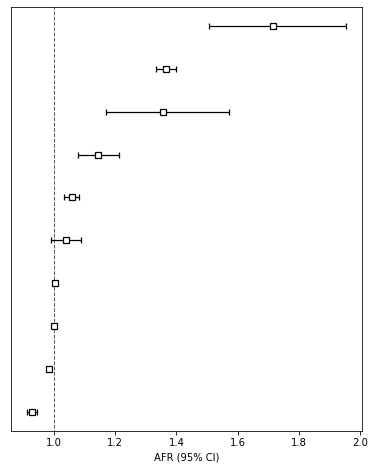

In [ ]:
# Print 95% CI AFRs in a plot
from lifelines import utils
from numpy import exp

plt.figure(figsize=(6.3,7.8))
ax = plt.gca()

z = utils.inv_normal_cdf(1 - aft.alpha / 2)
columns = [('lambda_',                    'slope_Q3_Swallowing'),
            ('lambda_',       'mean_Q1_2_3_mouth'),
            ('lambda_',               'slope_Q1_Speech'),
            ('lambda_',        'mean_Q7_Turning_in_Bed'),
            ('lambda_',            'weight_slope'),
            ('lambda_',  'mean_Q5_Cutting'),
            ('lambda_',    'fvc_mean'),
            ('lambda_',        'Creatinine_mean'),
            ('lambda_',    'onset_delta'),
            ('lambda_',           'Age')]

yaxis_locations = list(range(len(columns)))
log_afr = aft.params_.loc[columns].values.copy()

order = list(range(len(columns) - 1, -1, -1))

afr = exp(log_afr)
upper_errors = afr * (exp(z * aft.standard_errors_[columns].values) - 1)
lower_errors = afr * (1 - exp(-z * aft.standard_errors_[columns].values))
ax.errorbar(
      afr[order],
      yaxis_locations,
      xerr=np.vstack([lower_errors[order], upper_errors[order]]),
      c = "k",
      fmt = "s",
      markerfacecolor = 'white',
      markeredgewidth = 1.25,
      elinewidth = 1.25,
      capsize = 3   
)

ax.set_xlabel("AFR (%g%% CI)" % ((1 - aft.alpha) * 100))

best_ylim = ax.get_ylim()
ax.vlines(1 , -2, len(columns) + 1, linestyles="dashed", linewidths=1, alpha=0.65, color="k")
ax.set_ylim(best_ylim)

tick_labels = [columns[i] for i in order]

ax.set_yticks(yaxis_locations)
ax.set_yticklabels(tick_labels)
ax.yaxis.set_visible(True)

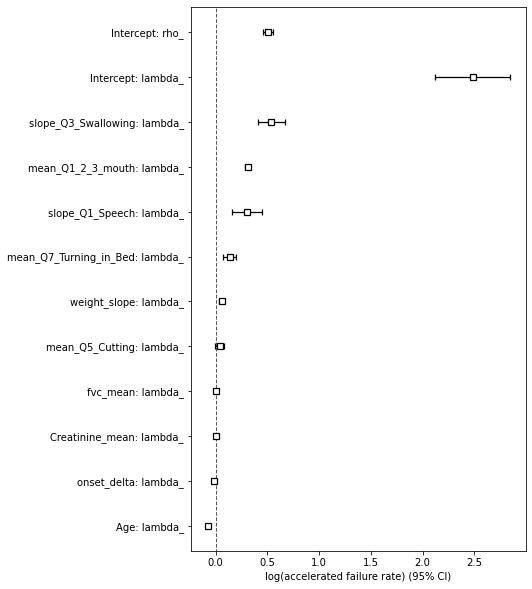

In [ ]:
from matplotlib import pyplot as plt

aft = WeibullAFTFitter().fit(df_train, 'time_opt', 'status_opt', ancillary=False)
plt.figure(figsize=(6,10))
aft.plot() # Print 95% CI log(AFR) in a plot

###(3) Re-fitting without insignificant feature

In [ ]:
# features with p-value higher than 0.05 are excluded
df_train_finalaft = df_train[['Age', 'onset_delta', 'fvc_mean', 'mean_Q1_2_3_mouth', 'mean_Q7_Turning_in_Bed',
       'slope_Q1_Speech', 'slope_Q3_Swallowing', 'weight_slope', 'status_opt', 'time_opt']]

aft = WeibullAFTFitter(penalizer = 0.2, l1_ratio = 0.2)
aft.fit(df_train_finalaft, duration_col='time_opt', event_col='status_opt', ancillary=False)

aft.print_summary()

<lifelines.WeibullAFTFitter: fitted with 2558 total observations, 1714 right-censored observations>
             duration col = 'time_opt'
                event col = 'status_opt'
                penalizer = 0.2
   number of observations = 2558
number of events observed = 844
           log-likelihood = -6207.96
         time fit was run = 2021-08-17 17:58:09 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
param   covariate                                                                                                                      
lambda_ Age                     -0.04       0.96       0.01            -0.06            -0.02                 0.95                 0.98
        fvc_mean                 0.00       1.00       0.00             0.00             0.01                 1.00                 1.01
        mean_Q1_2_3_mouth        0.28       1.32       0.01             0.25             0.30                 1.29                 1.35
        mean_Q7_Turning_in_Bed   0.09       1.09       0.02             0.04             0.13                 1.04                 1.14
        onset_delta             -0.01       0.99       0.00            -0.01            -0.00                 0.99                 1.00
        slope_Q1_Speech          0.21       1.24       0.08             0.06             0.37                 1.06                 1.45
        slope_Q3_Swallowing      0.44       1.56       0.07             0.30             0.58                 1.35                 1.79
        weight_slope             0.03       1.03       0.01             0.01             0.05                 1.01                 1.05
        Intercept                3.07      21.56       0.17             2.74             3.41                15.41                30.14
rho_    Intercept                0.39       1.48       0.02             0.35             0.44                 1.41                 1.55

                                   z      p   -log2(p)
param   covariate                                     
lambda_ Age                    -4.18 <0.005      15.07
        fvc_mean                3.54 <0.005      11.31
        mean_Q1_2_3_mouth      23.09 <0.005     389.45
        mean_Q7_Turning_in_Bed  3.71 <0.005      12.23
        onset_delta            -4.35 <0.005      16.18
        slope_Q1_Speech         2.66   0.01       7.00
        slope_Q3_Swallowing     6.15 <0.005      30.31
        weight_slope            2.78   0.01       7.54
        Intercept              17.95 <0.005     236.83
rho_    Intercept              16.46 <0.005     199.77
---
Concordance = 0.84
AIC = 12435.93
log-likelihood ratio test = 580.23 on 8 df
-log2(p) of ll-ratio test = 396.58

## 2) Cox Proportional Hazard Model

### (1) Tuning hyperparameter: GridSearchCV for Cox

In [ ]:
from sklearn.model_selection import GridSearchCV

cox_params ={'penalizer': [0, 1e-4, 1e-3, 1e-2, 0.1, 0.2, 0.5],
            'l1_ratio' : [0, 1e-4, 1e-3, 1e-2, 0.1, 0.2, 0.5] }

In [ ]:
from lifelines import CoxPHFitter
from lifelines.utils.sklearn_adapter import sklearn_adapter

X_cox = df_train.drop(columns = 'time_opt')
y_cox = df_train['time_opt']

base_class = sklearn_adapter(CoxPHFitter, event_col = 'status_opt')
cph = base_class()

grid_cv = GridSearchCV(cph, param_grid = cox_params, cv = 3, n_jobs = 1)
grid_cv.fit(X_cox, y_cox)

GridSearchCV(cv=3, error_score=nan,
             estimator=SkLearnCoxPHFitter(baseline_estimation_method='breslow',
                                          breakpoints=None, knots=None,
                                          l1_ratio=0.0, n_baseline_knots=None,
                                          penalizer=0.0, strata=None),
             iid='deprecated', n_jobs=1,
             param_grid={'l1_ratio': [0, 0.0001, 0.001, 0.01, 0.1, 0.2, 0.5],
                         'penalizer': [0, 0.0001, 0.001, 0.01, 0.1, 0.2, 0.5]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [ ]:
# Result
print(grid_cv.best_score_)
print(grid_cv.best_params_)

0.8382950669070374
{'l1_ratio': 0.2, 'penalizer': 0.1}


### (2) Fitting CoxPH model

In [ ]:
from lifelines import CoxPHFitter
cph = CoxPHFitter(penalizer=0.1, l1_ratio = 0.2)
cph.fit(df_train, 'time_opt', event_col='status_opt')
cph.print_summary() # Prints hazard ratio & p-value of each feature

<lifelines.CoxPHFitter: fitted with 2558 total observations, 1714 right-censored observations>
             duration col = 'time_opt'
                event col = 'status_opt'
                penalizer = 0.1
                 l1 ratio = 0.2
      baseline estimation = breslow
   number of observations = 2558
number of events observed = 844
   partial log-likelihood = -5601.03
         time fit was run = 2021-08-17 17:46:00 UTC

---
                         coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                      
Age                      0.06       1.06       0.01             0.03             0.09                 1.03                 1.09
onset_delta              0.01       1.01       0.00             0.01             0.02                 1.01                 1.02
fvc_mean                -0.01       0.99       0.00            -0.01            -0.00                 0.99                 1.00
Creatinine_mean         -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
mean_Q1_2_3_mouth       -0.42       0.66       0.02            -0.45            -0.38                 0.64                 0.68
mean_Q5_Cutting         -0.03       0.97       0.03            -0.09             0.03                 0.91                 1.03
mean_Q7_Turning_in_Bed  -0.13       0.87       0.04            -0.21            -0.06                 0.81                 0.94
slope_Q1_Speech         -0.38       0.69       0.12            -0.61            -0.15                 0.55                 0.86
slope_Q3_Swallowing     -0.75       0.47       0.11            -0.96            -0.54                 0.38                 0.58
weight_slope            -0.05       0.95       0.02            -0.09            -0.02                 0.92                 0.98

                            z      p   -log2(p)
covariate                                      
Age                      4.47 <0.005      17.00
onset_delta              4.84 <0.005      19.56
fvc_mean                -3.90 <0.005      13.33
Creatinine_mean         -0.03   0.98       0.04
mean_Q1_2_3_mouth      -23.65 <0.005     408.38
mean_Q5_Cutting         -1.00   0.32       1.66
mean_Q7_Turning_in_Bed  -3.39 <0.005      10.50
slope_Q1_Speech         -3.22 <0.005       9.58
slope_Q3_Swallowing     -7.06 <0.005      39.08
weight_slope            -3.31 <0.005      10.04
---
Concordance = 0.84
Partial AIC = 11222.05
log-likelihood ratio test = 777.36 on 10 df
-log2(p) of ll-ratio test = 530.91

In [ ]:
# Testing proportional-hazard assumption
print(cph.check_assumptions(df_train))

The ``p_value_threshold`` is set at 0.01. Even under the null hypothesis of no violations, some
covariates will be below the threshold by chance. This is compounded when there are many covariates.
Similarly, when there are lots of observations, even minor deviances from the proportional hazard
assumption will be flagged.

With that in mind, it's best to use a combination of statistical tests and visual tests to determine
the most serious violations. Produce visual plots using ``check_assumptions(..., show_plots=True)``
and looking for non-constant lines. See link [A] below for a full example.



<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 2558 total observations, 1714 right-censored observations>
         test_name = proportional_hazard_test

---
                             test_statistic      p  -log2(p)
Age                    km              0.00   0.96      0.06
                       rank            0.01   0.93      0.10
Creatinine_mean        km              0.02   0.88      0.19
                       rank            0.98   0.32      1.63
fvc_mean               km              0.29   0.59      0.76
                       rank            1.99   0.16      2.66
mean_Q1_2_3_mouth      km             27.10 <0.005     22.30
                       rank           30.03 <0.005     24.48
mean_Q5_Cutting        km              0.19   0.67      0.59
                       rank            0.30   0.59      0.77
mean_Q7_Turning_in_Bed km              0.43   0.51      0.97
                       rank            0.02   0.90      0.15
onset_delta            km              6.99   0.01      6.93
                       rank           11.65 <0.005     10.60
slope_Q1_Speech        km              3.10   0.08      3.68
                       rank            2.23   0.14      2.88
slope_Q3_Swallowing    km             46.56 <0.005     36.72
                       rank           63.58 <0.005     49.20
weight_slope           km              0.02   0.90      0.15
                       rank            0.13   0.72      0.48



1. Variable 'onset_delta' failed the non-proportional test: p-value is 0.0006.

   Advice 1: the functional form of the variable 'onset_delta' might be incorrect. That is, there
may be non-linear terms missing. The proportional hazard test used is very sensitive to incorrect
functional forms. See documentation in link [D] below on how to specify a functional form.

   Advice 2: try binning the variable 'onset_delta' using pd.cut, and then specify it in
`strata=['onset_delta', ...]` in the call in `.fit`. See documentation in link [B] below.

   Advice 3: try adding an interaction term with your time variable. See documentation in link [C]
below.


2. Variable 'mean_Q1_2_3_mouth' failed the non-proportional test: p-value is <5e-05.

   Advice 1: the functional form of the variable 'mean_Q1_2_3_mouth' might be incorrect. That is,
there may be non-linear terms missing. The proportional hazard test used is very sensitive to
incorrect functional forms. See documentation in link [D] below 

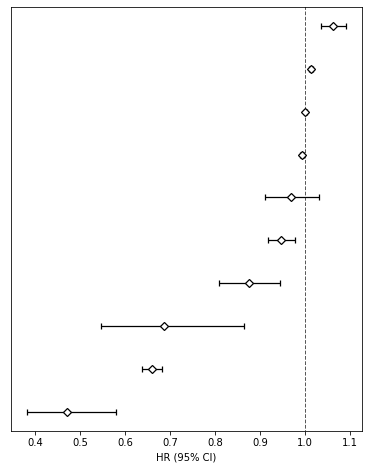

In [ ]:
# Print 95% CI Hazard ratios in a plot
plt.figure(figsize = (6.3,7.8))
ax = cph.plot(hazard_ratios=True, c='k', marker='D')
ax.yaxis.set_visible(True) #HR >1, or log(HR)>0 means that a feature increases the risk of event occurence

In [ ]:
df_train.columns

Index(['Age', 'onset_delta', 'fvc_mean', 'Creatinine_mean',
       'mean_Q1_2_3_mouth', 'mean_Q5_Cutting', 'mean_Q7_Turning_in_Bed',
       'slope_Q1_Speech', 'slope_Q3_Swallowing', 'weight_slope', 'status_opt',
       'time_opt'],
      dtype='object')

### (3) Re-fitting without insignificant feature

In [ ]:
# features with p-value higher than 0.05 are excluded
df_train_finalcox = df_train[['Age', 'onset_delta', 'fvc_mean',
       'mean_Q1_2_3_mouth', 'mean_Q7_Turning_in_Bed',
       'slope_Q1_Speech', 'slope_Q3_Swallowing',
        'weight_slope', 'status_opt', 'time_opt']]

from lifelines import CoxPHFitter
cph = CoxPHFitter(penalizer=0.1, l1_ratio = 0.2)
cph.fit(df_train_finalcox, 'time_opt', event_col='status_opt')
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 2558 total observations, 1714 right-censored observations>
             duration col = 'time_opt'
                event col = 'status_opt'
                penalizer = 0.1
                 l1 ratio = 0.2
      baseline estimation = breslow
   number of observations = 2558
number of events observed = 844
   partial log-likelihood = -5601.53
         time fit was run = 2021-08-17 17:57:39 UTC

---
                         coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                      
Age                      0.06       1.06       0.01             0.03             0.08                 1.03                 1.09
onset_delta              0.01       1.01       0.00             0.01             0.02                 1.01                 1.02
fvc_mean                -0.01       0.99       0.00            -0.01            -0.00                 0.99                 1.00
mean_Q1_2_3_mouth       -0.42       0.66       0.02            -0.45            -0.38                 0.64                 0.68
mean_Q7_Turning_in_Bed  -0.15       0.86       0.03            -0.22            -0.09                 0.80                 0.92
slope_Q1_Speech         -0.38       0.68       0.12            -0.61            -0.15                 0.54                 0.86
slope_Q3_Swallowing     -0.76       0.47       0.11            -0.97            -0.55                 0.38                 0.58
weight_slope            -0.06       0.95       0.02            -0.09            -0.02                 0.92                 0.98

                            z      p   -log2(p)
covariate                                      
Age                      4.36 <0.005      16.26
onset_delta              4.79 <0.005      19.21
fvc_mean                -4.01 <0.005      14.01
mean_Q1_2_3_mouth      -23.68 <0.005     409.36
mean_Q7_Turning_in_Bed  -4.49 <0.005      17.08
slope_Q1_Speech         -3.26 <0.005       9.83
slope_Q3_Swallowing     -7.08 <0.005      39.34
weight_slope            -3.32 <0.005      10.12
---
Concordance = 0.84
Partial AIC = 11219.05
log-likelihood ratio test = 776.36 on 8 df
-log2(p) of ll-ratio test = 536.79

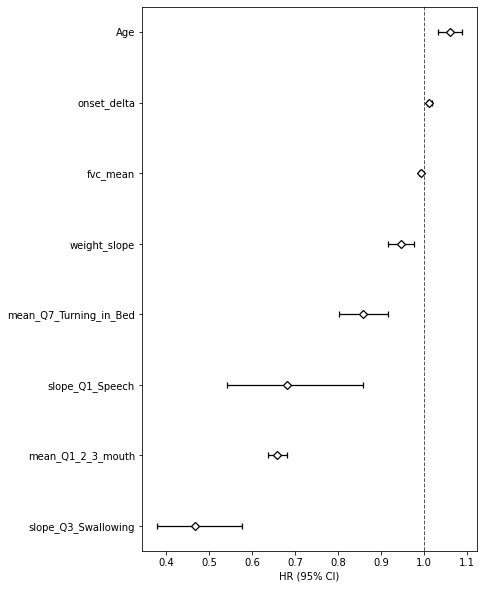

In [ ]:
# Print 95% CI Hazard ratios in a plot
plt.figure(figsize=(6.3, 7.8))
ax = cph.plot(hazard_ratios=True, c='k', marker='D')
ax.yaxis.set_visible(True)

## 3) Random Survival Forest model

In [ ]:
!pip install --upgrade pip
!pip uninstall --yes --quiet osqp
!pip install -U scikit-survival

In [ ]:
from sksurv.ensemble import RandomSurvivalForest

In [ ]:
# Random Survival Forests requires array-type data, thus additional preprocessing was needed
dic = {1:True, 0:False}

df_train_rsf = df_train.iloc[:, -2:][['status_opt', 'time_opt']]
df_train_rsf = df_train_rsf.replace({'status_opt':dic})

In [ ]:
arr_1 = list(tuple(x) for x in df_train_rsf.to_records(index=False))
dt = np.dtype('bool, float')
y_train_rsf = np.array(arr_1, dtype=dt)
y_train_rsf.dtype.names=['cens', 'time']
y_train_rsf

array([(False, 274.), ( True,  35.), (False, 154.), ..., ( True,  91.),
       (False, 266.), (False, 126.)],
      dtype=[('cens', '?'), ('time', '<f8')])

###(1) GridSearchCV for RSF

In [ ]:
from sklearn.model_selection import GridSearchCV

params ={ 'n_estimators':[100],
          'max_features':['auto', 'sqrt','log2', None],
          'min_samples_leaf':[8,12,18],
          'min_samples_split':[8,16,20] }

In [ ]:
rf = RandomSurvivalForest(random_state=20, n_jobs=-1)
grid_cv3 = GridSearchCV(rf, param_grid=params, cv=2, n_jobs=-1)
GG = grid_cv3.fit(df_train.iloc[:,:-2], y_train_rsf)

In [ ]:
# Result
print(grid_cv3.best_score_)
print(grid_cv3.best_params_)

0.843955419106112
{'max_features': 'auto', 'min_samples_leaf': 12, 'min_samples_split': 8, 'n_estimators': 100}


###(2) Fitting RSF model

In [ ]:
rsf = RandomSurvivalForest(n_estimators=100,
                           min_samples_split=8,
                           min_samples_leaf=18,
                           max_features="auto",
                           n_jobs=-1,
                           random_state=20)
rsf.fit(df_train.iloc[:,:-2], y_train_rsf)

In [ ]:
feature_names = df_train.iloc[:, :-2].columns.tolist()
feature_names

['Age',
 'onset_delta',
 'fvc_mean',
 'Creatinine_mean',
 'mean_Q1_2_3_mouth',
 'mean_Q5_Cutting',
 'mean_Q7_Turning_in_Bed',
 'slope_Q1_Speech',
 'slope_Q3_Swallowing',
 'weight_slope']

In [ ]:
pip install eli5

In [ ]:
import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(rsf, n_iter=15, random_state=20)
perm.fit(df_train.iloc[:, :-2], y_train_rsf)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)


PermutationImportance(cv='prefit',
                      estimator=RandomSurvivalForest(bootstrap=True,
                                                     max_depth=None,
                                                     max_features='auto',
                                                     max_leaf_nodes=None,
                                                     max_samples=None,
                                                     min_samples_leaf=18,
                                                     min_samples_split=8,
                                                     min_weight_fraction_leaf=0.0,
                                                     n_estimators=100,
                                                     n_jobs=-1, oob_score=False,
                                                     random_state=20, verbose=0,
                                                     warm_start=False),
                      n_iter=15, random_state=20, refit=True, scoring=No

In [ ]:
eli5.explain_weights_df(perm, feature_names=feature_names).describe()

,weight,std
count,10.000000,10.000000
mean,0.032335,0.001559
std,0.061539,0.001777
min,0.005694,0.000473
25%,0.008694,0.000561
50%,0.012712,0.001056
75%,0.018087,0.001614
max,0.206649,0.006392


In [ ]:
eli5.show_weights(perm, feature_names=feature_names)

Weight,Feature
0.2066 ± 0.0128,mean_Q1_2_3_mouth
0.0251 ± 0.0037,slope_Q3_Swallowing
0.0186 ± 0.0029,fvc_mean
0.0165 ± 0.0033,onset_delta
0.0148 ± 0.0028,mean_Q7_Turning_in_Bed
0.0106 ± 0.0011,slope_Q1_Speech
0.0105 ± 0.0012,weight_slope
0.0081 ± 0.0015,Age
0.0068 ± 0.0009,mean_Q5_Cutting
0.0057 ± 0.0010,Creatinine_mean


In [ ]:
# Because 'eli5.show_weights' only provides html object, Feature importance written as a dataframe in csv dtype were separately made in excel.
from google.colab import files 
uploaded = files.upload()

Saving BB2 final.csv to BB2 final.csv


In [ ]:
import io
Feat_imp = pd.read_csv(io.BytesIO(uploaded['BB2 final.csv'])) 

In [ ]:
Feat_imp = Feat_imp[['Unnamed: 2', 'weight', 'max', 'min']]

In [ ]:
Feat_imp

,Unnamed: 2,weight,max,min
0,mean_Q1_2_3_mouth,0.2066,0.2194,0.1938
1,slope_Q3_Swallowing,0.0251,0.0288,0.0214
2,fvc_mean,0.0186,0.0215,0.0157
3,onset_delta,0.0165,0.0198,0.0132
4,mean_Q7_Turning_in_Bed,0.0148,0.0176,0.0120
5,slope_Q1_Speech,0.0106,0.0117,0.0095
6,weight_slope,0.0105,0.0117,0.0093
7,Age,0.0081,0.0096,0.0066
8,mean_Q5_Cutting,0.0068,0.0077,0.0059
9,Creatinine_mean,0.0057,0.0067,0.0047


In [ ]:
Feat_imp = Feat_imp.transpose()
Feat_imp.columns = ['mean_Q1_2_3_mouth','slope_Q3_Swallowing', 'fvc_mean','onset_delta', 'mean_Q7_Turning_in_Bed', 'slope_Q1_Speech',
         'weight_slope',  'Age', 'mean_Q5_Cutting	', 'Creatinine_mean']
Feat_imp = Feat_imp.iloc[1:, :]
Feat_imp

,mean_Q1_2_3_mouth,slope_Q3_Swallowing,fvc_mean,onset_delta,mean_Q7_Turning_in_Bed,slope_Q1_Speech,weight_slope,Age,mean_Q5_Cutting\t,Creatinine_mean
weight,0.2066,0.0251,0.0186,0.0165,0.0148,0.0106,0.0105,0.0081,0.0068,0.0057
max,0.2194,0.0288,0.0215,0.0198,0.0176,0.0117,0.0117,0.0096,0.0077,0.0067
min,0.1938,0.0214,0.0157,0.0132,0.012,0.0095,0.0093,0.0066,0.0059,0.0047


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0, flags=flags)


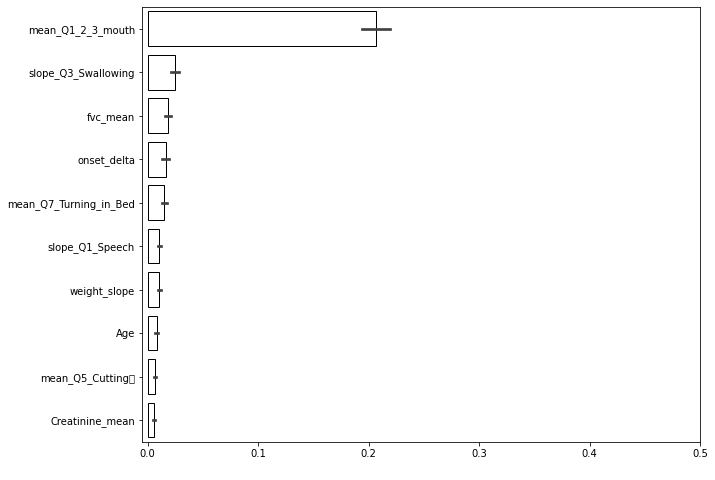

In [ ]:
df = pd.DataFrame(data=Feat_imp, columns=['mean_Q1_2_3_mouth','slope_Q3_Swallowing', 'fvc_mean','onset_delta', 'mean_Q7_Turning_in_Bed', 'slope_Q1_Speech',
         'weight_slope',  'Age', 'mean_Q5_Cutting	', 'Creatinine_mean'])

import matplotlib
matplotlib.rc('axes',edgecolor='k')

fig, ax = plt.subplots()
ax.grid(False)
fig.set_size_inches(10, 8)
sns.barplot(x="value", y="variable", data=pd.melt(df), color='white', edgecolor='k', dodge=False)
ax.set_xlabel(' ')
ax.set_xlim([-0.005,0.5])
ax.set_ylabel('')
ax.yaxis.set_visible(True)

### (3) Re-fitting without insignificant feature

In [ ]:
# features with feature-weight less than 0.01 are excluded
df_train_finalrsf = df_train[['onset_delta', 'fvc_mean',
       'mean_Q1_2_3_mouth', 'mean_Q7_Turning_in_Bed',
       'slope_Q1_Speech', 'slope_Q3_Swallowing', 
        'weight_slope', 'status_opt', 'time_opt']]

In [ ]:
rsf = RandomSurvivalForest(n_estimators=100,
                           min_samples_split=8,
                           min_samples_leaf=18,
                           max_features="auto",
                           n_jobs=-1,
                           random_state=20)
rsf.fit(df_train_finalrsf.iloc[:,:-2], y_train_rsf)

feature_names = df_train_finalrsf.iloc[:, :-2].columns.tolist()

perm = PermutationImportance(rsf, n_iter=15, random_state=20)
perm.fit(df_train_finalrsf.iloc[:, :-2], y_train_rsf)

eli5.show_weights(perm, feature_names=feature_names)

Weight,Feature
0.1960 ± 0.0175,mean_Q1_2_3_mouth
0.0300 ± 0.0034,slope_Q3_Swallowing
0.0272 ± 0.0038,mean_Q7_Turning_in_Bed
0.0257 ± 0.0040,onset_delta
0.0248 ± 0.0035,fvc_mean
0.0168 ± 0.0023,weight_slope
0.0113 ± 0.0013,slope_Q1_Speech


## 2. Evaluating model performances

## 1) Repeated 5-fold cross validation on Training set

### (1) Accelerated Failure Time

In [ ]:
from lifelines import WeibullAFTFitter
aft = WeibullAFTFitter(penalizer = 0.2, l1_ratio = 0.2)
C_Idx1 = np.array([])
random_num_list = [10,20,30,40,50,60,70,80,90,100]

for i in random_num_list:
    df_train_aft = df_train_finalaft.sample(n=len(df_train_finalaft), random_state=i)
    
    aft.fit(df_train_aft.iloc[0:2047,:], 'time_opt', event_col='status_opt')
    sco_1 = concordance_index(df_train_aft.iloc[2047:,:]['time_opt'], aft.predict_median(df_train_aft.iloc[2047:,:]), df_train_aft.iloc[2047:,:]['status_opt'])
    
    aft.fit(df_train_aft.iloc[512:,:], 'time_opt', event_col='status_opt')
    sco_2 = concordance_index(df_train_aft.iloc[0:512,:]['time_opt'], aft.predict_median(df_train_aft.iloc[0:512,:]), df_train_aft.iloc[0:512,:]['status_opt'])

    aft.fit(pd.concat([df_train_aft.iloc[0:512],df_train_aft.iloc[1024:]]), 'time_opt', event_col='status_opt')
    sco_3 = concordance_index(df_train_aft.iloc[512:1024,:]['time_opt'], aft.predict_median(df_train_aft.iloc[512:1024,:]), df_train_aft.iloc[512:1024,:]['status_opt'])

    aft.fit(pd.concat([df_train_aft.iloc[0:1024],df_train_aft.iloc[1536:]]), 'time_opt', event_col='status_opt')
    sco_4 = concordance_index(df_train_aft.iloc[1024:1536,:]['time_opt'], aft.predict_median(df_train_aft.iloc[1024:1536,:]), df_train_aft.iloc[1024:1536,:]['status_opt'])

    aft.fit(pd.concat([df_train_aft.iloc[0:1536],df_train_aft.iloc[2047:]]), 'time_opt', event_col='status_opt')
    sco_5 = concordance_index(df_train_aft.iloc[1536:2047,:]['time_opt'], aft.predict_median(df_train_aft.iloc[1536:2047,:]), df_train_aft.iloc[1536:2047,:]['status_opt'])
    
    C_Idx1 = np.append (C_Idx1, [sco_1, sco_2, sco_3, sco_4, sco_5])
print(C_Idx1)

[0.82059274 0.84501364 0.84535683 0.84801855 0.83435386 0.83841496
 0.82660624 0.83169744 0.84124245 0.85452684 0.85041478 0.82975504
 0.84685525 0.85899231 0.79633976 0.81734873 0.85818557 0.8068426
 0.8416109  0.85912157 0.81481636 0.85817013 0.84028256 0.83304746
 0.83489781 0.82582075 0.84085141 0.82802318 0.84783204 0.84953794
 0.81183553 0.85553201 0.85387337 0.83169379 0.8380839  0.87377555
 0.81214641 0.82542992 0.84915596 0.8282974  0.84702454 0.81506731
 0.84596739 0.83990921 0.83963452 0.83188031 0.84003808 0.85587435
 0.82219358 0.8291862 ]


### (2) Cox proportional hazard model

In [ ]:
from lifelines.utils import concordance_index

In [ ]:
# 5-fold cross validation is repeated 10 times, 50 C-index values are returned as a result
cph = CoxPHFitter(penalizer = 0.1, l1_ratio = 0.2)
C_Idx2 = np.array([])
random_num_list = [10,20,30,40,50,60,70,80,90,100]

for i in random_num_list:
    df_train_cox = df_train_finalcox.sample(n=len(df_train_finalcox), random_state=i)
    
    cph.fit(df_train_cox.iloc[0:2047,:], 'time_opt', event_col='status_opt')
    sco_1 = concordance_index(df_train_cox.iloc[2047:,:]['time_opt'], -cph.predict_partial_hazard(df_train_cox.iloc[2047:,:]), df_train_cox.iloc[2047:,:]['status_opt'])
    
    cph.fit(df_train_cox.iloc[512:,:], 'time_opt', event_col='status_opt')
    sco_2 = concordance_index(df_train_cox.iloc[0:512,:]['time_opt'], -cph.predict_partial_hazard(df_train_cox.iloc[0:512,:]), df_train_cox.iloc[0:512,:]['status_opt'])

    cph.fit(pd.concat([df_train_cox.iloc[0:512],df_train_cox.iloc[1024:]]), 'time_opt', event_col='status_opt')
    sco_3 = concordance_index(df_train_cox.iloc[512:1024,:]['time_opt'], -cph.predict_partial_hazard(df_train_cox.iloc[512:1024,:]), df_train_cox.iloc[512:1024,:]['status_opt'])

    cph.fit(pd.concat([df_train_cox.iloc[0:1024],df_train_cox.iloc[1536:]]), 'time_opt', event_col='status_opt')
    sco_4 = concordance_index(df_train_cox.iloc[1024:1536,:]['time_opt'], -cph.predict_partial_hazard(df_train_cox.iloc[1024:1536,:]), df_train_cox.iloc[1024:1536,:]['status_opt'])

    cph.fit(pd.concat([df_train_cox.iloc[0:1536],df_train_cox.iloc[2047:]]), 'time_opt', event_col='status_opt')
    sco_5 = concordance_index(df_train_cox.iloc[1536:2047,:]['time_opt'], -cph.predict_partial_hazard(df_train_cox.iloc[1536:2047,:]), df_train_cox.iloc[1536:2047,:]['status_opt'])
    
    C_Idx2 = np.append (C_Idx2, [sco_1, sco_2, sco_3, sco_4, sco_5])

print(C_Idx2)

[0.8204452  0.84400569 0.84377132 0.84652173 0.83571038 0.83827165
 0.82562694 0.83273736 0.84221541 0.85197679 0.84997817 0.82971943
 0.84792456 0.85930343 0.79487813 0.81718245 0.85854861 0.80821946
 0.84208054 0.85720782 0.81285255 0.85696235 0.84058278 0.83339051
 0.83541143 0.82751181 0.84094404 0.82786071 0.84717535 0.84858663
 0.81159474 0.85564553 0.85327774 0.83233769 0.83707457 0.8767258
 0.81100768 0.82507351 0.85001835 0.82665149 0.84752012 0.81465309
 0.84892154 0.83913916 0.83738135 0.83219247 0.84153651 0.85499454
 0.82256458 0.8279761 ]


### (3) Random Survival Forest

In [ ]:
df_train_finalrsf2 = df_train_finalrsf.replace({'status_opt':dic})
df_train_finalrsf2

,onset_delta,fvc_mean,mean_Q1_2_3_mouth,mean_Q7_Turning_in_Bed,slope_Q1_Speech,slope_Q3_Swallowing,weight_slope,status_opt,time_opt
0,-56.087671,101.250000,11.000000,2.600000,0.000000,0.000000,-2.703704,False,274
1,-35.178082,51.000000,8.500000,4.000000,0.000000,-0.334249,-3.309066,True,35
2,-16.898630,89.600000,11.000000,4.000000,0.000000,0.362103,-0.601648,False,154
3,-18.739726,71.000000,8.500000,0.500000,-0.633681,0.000000,-1.933900,True,187
4,-12.000000,114.000000,12.000000,3.000000,0.000000,0.000000,0.000000,False,401
...,...,...,...,...,...,...,...,...,...
2558,-20.120548,73.333333,8.333333,4.000000,0.000000,0.000000,1.310900,False,64
2559,-32.843836,75.000000,10.000000,3.000000,0.010513,0.164577,-3.206060,False,390
2560,-16.175342,100.800000,8.500000,4.000000,-0.370935,-0.370935,-0.534799,True,91
2561,-94.191781,50.250000,12.000000,2.800000,0.000000,0.000000,-0.217262,False,266


In [ ]:
C_Idx3 = np.array([])
random_num_list = [10,20,30,40,50,60,70,80,90,100]

for i in random_num_list:
    df_train_rsf = df_train_finalrsf2.sample(n=len(df_train_finalrsf2), random_state=i)
    
    y_train_rsf_1 = np.array(list(tuple(x) for x in df_train_rsf.iloc[:2047,-2:].to_records(index=False)), dtype=dt)
    y_test_rsf_1 = np.array(list(tuple(x) for x in df_train_rsf.iloc[2047:,-2:].to_records(index=False)), dtype=dt)
    
    y_train_rsf_2 = np.array(list(tuple(x) for x in df_train_rsf.iloc[512:,-2:].to_records(index=False)), dtype=dt)
    y_test_rsf_2 = np.array(list(tuple(x) for x in df_train_rsf.iloc[0:512,-2:].to_records(index=False)), dtype=dt)
    
    y_train_rsf_3 = np.array(list(tuple(x) for x in pd.concat([df_train_rsf.iloc[0:512,-2:],df_train_rsf.iloc[1024:,-2:]]).to_records(index=False)), dtype=dt)
    y_test_rsf_3 = np.array(list(tuple(x) for x in df_train_rsf.iloc[512:1024,-2:].to_records(index=False)), dtype=dt)
    
    y_train_rsf_4 = np.array(list(tuple(x) for x in pd.concat([df_train_rsf.iloc[0:1024,-2:],df_train_rsf.iloc[1536:,-2:]]).to_records(index=False)), dtype=dt)
    y_test_rsf_4 = np.array(list(tuple(x) for x in df_train_rsf.iloc[1024:1536,-2:].to_records(index=False)), dtype=dt)
    
    y_train_rsf_5 = np.array(list(tuple(x) for x in pd.concat([df_train_rsf.iloc[0:1536,-2:],df_train_rsf.iloc[2047:,-2:]]).to_records(index=False)), dtype=dt)
    y_test_rsf_5 = np.array(list(tuple(x) for x in df_train_rsf.iloc[1536:2047,-2:].to_records(index=False)), dtype=dt)
    
    
    rsf.fit(df_train_rsf.iloc[0:2047,:-2], y_train_rsf_1)
    sco_1 = rsf.score(df_train_rsf.iloc[2047:,:-2], y_test_rsf_1)
    
    rsf.fit(df_train_rsf.iloc[512:,:-2], y_train_rsf_2)
    sco_2 = rsf.score(df_train_rsf.iloc[0:512,:-2], y_test_rsf_2)
    
    rsf.fit(pd.concat([df_train_rsf.iloc[0:512,:-2],df_train_rsf.iloc[1024:,:-2]]), y_train_rsf_3)
    sco_3 = rsf.score(df_train_rsf.iloc[512:1024,:-2], y_test_rsf_3)
    
    rsf.fit(pd.concat([df_train_rsf.iloc[0:1024,:-2],df_train_rsf.iloc[1536:,:-2]]), y_train_rsf_4)
    sco_4 = rsf.score(df_train_rsf.iloc[1024:1536,:-2], y_test_rsf_4)
    
    rsf.fit(pd.concat([df_train_rsf.iloc[0:1536,:-2],df_train_rsf.iloc[2047:,:-2]]), y_train_rsf_5)
    sco_5 = rsf.score(df_train_rsf.iloc[1536:2047,:-2], y_test_rsf_5)
    
    C_Idx3 = np.append (C_Idx3, [sco_1, sco_2, sco_3, sco_4, sco_5])

print(C_Idx3)

[0.83424008 0.85971778 0.83765049 0.85117646 0.83644516 0.85124145
 0.83294289 0.82604174 0.84605217 0.85392446 0.85142087 0.8280282
 0.86483912 0.85854291 0.80247447 0.82998614 0.85138337 0.82148743
 0.84149348 0.87265045 0.83560356 0.85777992 0.83532009 0.83405756
 0.83642096 0.83087449 0.83925826 0.84668845 0.85656956 0.84629572
 0.81194666 0.85994021 0.85497437 0.84419603 0.84236344 0.87738141
 0.81943064 0.83188096 0.85746789 0.83421047 0.85790747 0.81876079
 0.86181756 0.82967556 0.83942163 0.84652947 0.85562176 0.85173599
 0.82043622 0.82850552]


### (4) Comparing C-index values between Cox & AFT & RSF

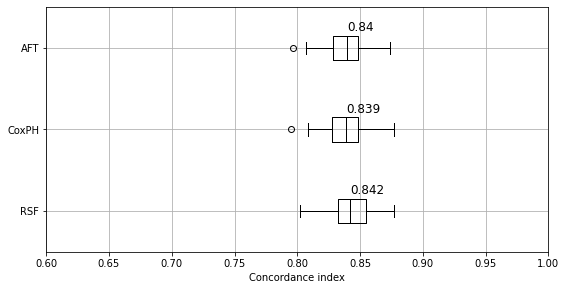

In [ ]:
df = pd.DataFrame([C_Idx1, C_Idx2,C_Idx3], index=['CoxPH', 'RSF','AFT'])
df2 = df.transpose()

colors = ['#000000', '#000000', '#ff7f00']
colors_setosa = dict(color=colors[0])
colors_versicolor = dict(color=colors[1])
colors_versicolor2 = dict(color=colors[2])

aft_median = np.median(df2['AFT'])
cox_median = np.median(df2['CoxPH'])
rsf_median = np.median(df2['RSF'])
aft_std = np.std(df2['AFT'])
cox_std = np.std(df2['CoxPH'])
rsf_std = np.std(df2['RSF'])

fig, ax = plt.subplots(figsize=(9,4.5))
ax = df2.boxplot(column=[ 'RSF', 'CoxPH', 'AFT'], vert=False, color = 'k')
plt.annotate(str(np.round(aft_median,3)), xy=(aft_median, 0.8)
                , xytext=(aft_median, 3.205) , fontsize=12)
plt.annotate(str(np.round(cox_median,3)), xy=(aft_median, 0.8)
                , xytext=(cox_median, 2.205) , fontsize=12)
plt.annotate(str(np.round(rsf_median,3)), xy=(aft_median, 0.8)
                , xytext=(rsf_median, 1.205) , fontsize=12)
plt.xlim([.6,1.0])
plt.xlabel('Concordance index')
plt.show()

In [ ]:
print(aft_median)
print(cox_median)
print(rsf_median)
print(aft_std)
print(cox_std)
print(rsf_std)

0.8397718696552205
0.8387054032830821
0.8419284608948359
0.015582818151902366
0.015743934222872714
0.015482766596636164


## 2) Demonstrations: Individual Prediction on Test set

In [ ]:
df_test

,SubjectID,Age,onset_delta,fvc_mean,Creatinine_slope,mean_Q1_2_3_mouth,mean_Q5_Cutting,mean_Q7_Turning_in_Bed,slope_Q1_Speech,slope_Q2_Salivation,slope_Q3_Swallowing,slope_Q10_Respiratory,weight_slope,status_opt,time_opt
405,112610.0,9.0,-21.933333,45.055197,-5.586735,11.0,2.0,2.00,0.000000,0.000000,0.0,0.000000,0.000000,0,595
2635,778226.0,7.0,-5.600000,83.500000,0.000000,12.0,2.5,3.00,0.000000,0.000000,0.0,0.000000,-1.126543,1,510
1695,509699.0,7.0,-26.066667,83.500000,-2.966297,10.5,3.5,3.75,0.668498,0.334249,0.0,-0.334249,0.896704,1,119
2645,781188.0,3.0,-17.133333,72.666667,0.000000,12.0,3.0,3.00,0.000000,0.000000,0.0,0.000000,-0.342723,0,372
1980,585359.0,9.0,-31.500000,97.666667,-3.787089,11.0,4.0,3.00,0.000000,0.000000,0.0,0.000000,0.171362,1,322


In [ ]:
test_1 = df_test.drop(columns=['SubjectID','time_opt', 'status_opt'])

Text(0.5, 1.0, 'AFT')

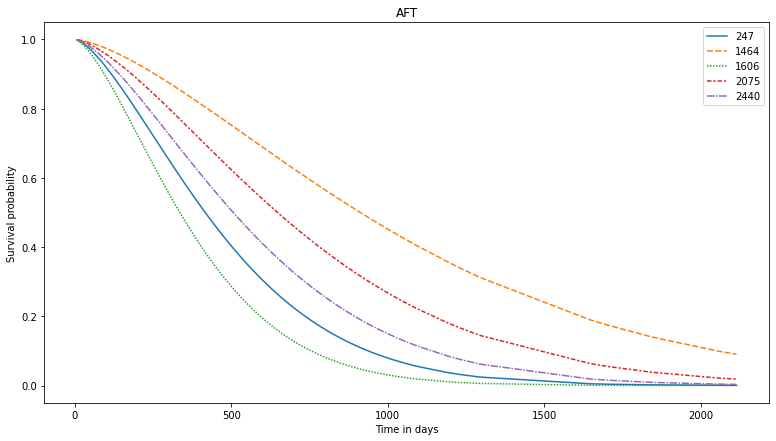

In [ ]:
tes_1_aft = test_1[['Age', 'onset_delta', 'fvc_mean',
       'mean_Q1_2_3_mouth', 'mean_Q7_Turning_in_Bed',
       'slope_Q1_Speech', 'slope_Q3_Swallowing', 
        'weight_slope']]

aft = WeibullAFTFitter(penalizer = 0.2, l1_ratio = 0.2)
aft.fit(df_train_finalaft, duration_col='time_opt', event_col='status_opt', ancillary=False)

fig, ax = plt.subplots(figsize=(13,7))
result_aft = aft.predict_survival_function(tes_1_aft)
ax = sns.lineplot(data = result_aft)
ax.set(xlabel='Time in days', ylabel='Survival probability')
ax.set_title("AFT")

Text(0.5, 1.0, 'COXPH')

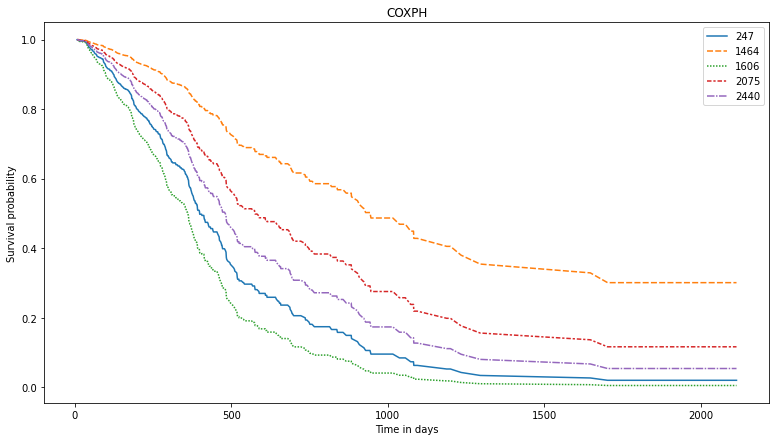

In [ ]:
tes_1_cox = test_1[['Age', 'onset_delta', 'fvc_mean',
       'mean_Q1_2_3_mouth', 'mean_Q7_Turning_in_Bed',
       'slope_Q1_Speech', 'slope_Q3_Swallowing', 
        'weight_slope']]

cph = CoxPHFitter(penalizer=0.1, l1_ratio = 0.2)
cph.fit(df_train_finalcox, 'time_opt', event_col='status_opt')

fig, ax = plt.subplots(figsize=(13,7))
result_cph = cph.predict_survival_function(tes_1_cox)
ax = sns.lineplot(data = result_cph)
ax.set(xlabel='Time in days', ylabel='Survival probability')
ax.set_title("COXPH")

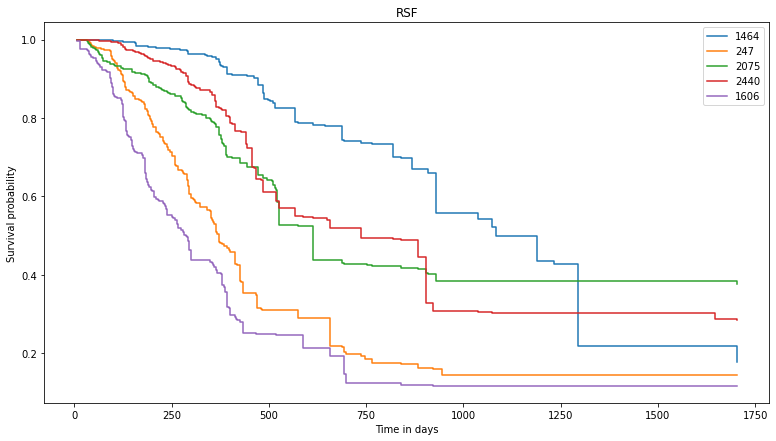

In [ ]:
tes_1_rsf = test_1[['onset_delta', 'fvc_mean',
       'mean_Q1_2_3_mouth', 'mean_Q7_Turning_in_Bed',
       'slope_Q1_Speech', 'slope_Q3_Swallowing', 
        'weight_slope']]

rsf = RandomSurvivalForest(n_estimators=100,
                           min_samples_split=8,
                           min_samples_leaf=18,
                           max_features="auto",
                           n_jobs=-1,
                           random_state=20)
rsf.fit(df_train_finalrsf.iloc[:,:-2], y_train_rsf)

result_rsf = rsf.predict_survival_function(tes_1_rsf, return_array=True)
fig, ax = plt.subplots(figsize=(13,7))
for i, s in enumerate(result_rsf):
    plt.step(rsf.event_times_, s, where="post")
    
plt.legend(labels = list(test_1.index))
plt.ylabel("Survival probability")
plt.xlabel("Time in days")
plt.title("RSF")
plt.show()

# 3) Group Stratification by median predicted time

## (1) Accelerated Failure Time model

In [ ]:
# Extract median probability time
aft_median = pd.concat([opt_data['SubjectID'],aft.predict_median(df_train_finalaft)], axis=1)
aft_median

,SubjectID,0
0,329.0,876.166439
1,708.0,260.573105
2,902.0,641.042546
3,1736.0,204.024693
4,2492.0,814.025135
...,...,...
2558,998756.0,294.341634
2559,999166.0,445.889760
2560,999823.0,261.686931
2561,999880.0,1197.536223


In [ ]:
# Check how many subjects have infinity values on median prob time
print('There are ' + str(aft_median.replace([np.inf,-np.inf], np.nan).isnull().sum(axis = 0).iloc[1]) + ' inf values in aft_median')

There are 0 inf values in aft_median


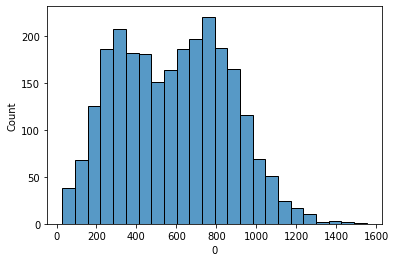

In [ ]:
sns.histplot(x = aft_median[0])

In [ ]:
# Find 25 and 75 percentile range of median prob time
aft_median.describe()

,SubjectID,0
count,2558.000000,2558.000000
mean,510459.784206,585.730483
std,291454.772392,274.097541
min,329.000000,29.539911
25%,264231.750000,351.769077
50%,517427.500000,593.170346
75%,770337.750000,793.393296
max,999990.000000,1553.761420


In [ ]:
# Categorize into 3 group based on interquartile range
aft_slow_list = list(aft_median[aft_median[0] >= 793.393296]['SubjectID'])
aft_intermediate_list = list(aft_median[(aft_median[0] >= 351.769077) & (cph_median[0.5] < 793.393296)]['SubjectID'])
aft_rapid_list = list(aft_median[aft_median[0]  < 351.769077]['SubjectID'])
X_aft_slow = opt_data[opt_data['SubjectID'].isin(aft_slow_list)]
X_aft_intermediate = opt_data[opt_data['SubjectID'].isin(aft_intermediate_list)]
X_aft_rapid = opt_data[opt_data['SubjectID'].isin(aft_rapid_list)]

In [ ]:
# Create a representative virtual patient with each feature's mean value
VIRT_aft_slow = pd.DataFrame(X_aft_slow.mean()).transpose().iloc[:, 1:-2][finalaft_feature_list]
VIRT_aft_intermediate = pd.DataFrame(X_aft_intermediate.mean()).transpose().iloc[:, 1:-2][finalaft_feature_list]
VIRT_aft_rapid = pd.DataFrame(X_aft_rapid.mean()).transpose().iloc[:, 1:-2][finalaft_feature_list]

In [ ]:
result_aft_slow = aft.predict_survival_function(VIRT_aft_slow)
result_aft_intermediate = aft.predict_survival_function(VIRT_aft_intermediate)
result_aft_rapid = aft.predict_survival_function(VIRT_aft_rapid)

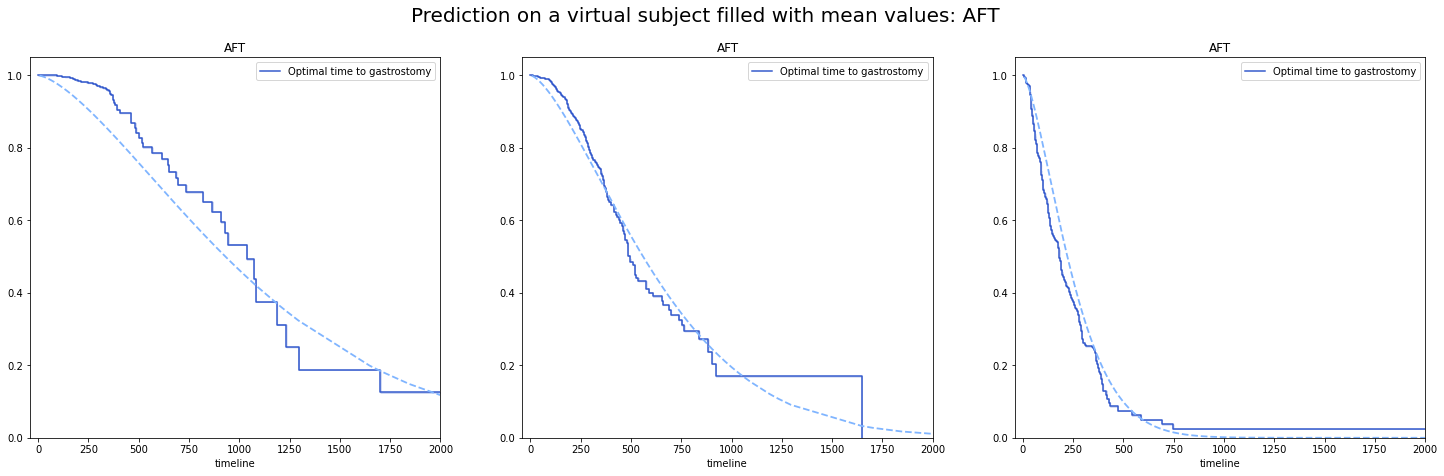

In [ ]:
# Compare KM curve and AFT-prediction curve in each group
# KM in solid lines, pred curve in dotted lines
plt.figure(figsize=(25, 7))

plt.subplot(131)
OPT = kmf.fit(X_aft_slow["time_opt"], X_aft_slow["status_opt"], label='Optimal time to gastrostomy', alpha=1)
ax_kmf = OPT.plot(color='#3359cc', linewidth=1.5)
plt.title("Slow")
plt.plot(result_aft_slow.index, result_aft_slow[0], marker='None', color='#80b5ff', linestyle="--", linewidth=1.8)
plt.title("AFT")
plt.xlim([-40,2000])
plt.ylim([0,1.05])

plt.subplot(132)
OPT = kmf.fit(X_aft_intermediate["time_opt"], X_aft_intermediate["status_opt"], label='Optimal time to gastrostomy', alpha=1)
ax_kmf = OPT.plot(color='#3359cc', linewidth=1.5)
plt.title("Intermediate")
plt.plot(result_aft_intermediate.index, result_aft_intermediate[0], marker='None', color='#80b5ff', linestyle="--", linewidth=1.8)
plt.title("AFT")
plt.xlim([-40,2000])
plt.ylim([0,1.05])

plt.subplot(133)
OPT = kmf.fit(X_aft_rapid["time_opt"], X_aft_rapid["status_opt"], label='Optimal time to gastrostomy', alpha=1)
ax_kmf = OPT.plot(color='#3359cc', linewidth=1.5)
plt.title("Rapid")
plt.plot(result_aft_rapid.index, result_aft_rapid[0], marker='None', color='#80b5ff', linestyle="--", linewidth=1.8)
plt.title("AFT")
plt.xlim([-40,2000])
plt.ylim([0,1.05])

plt.suptitle('Prediction on a virtual subject filled with mean values: AFT', fontsize=20)

plt.show()

## (2) Cox proportional hazard model

In [ ]:
# Extract median probability time
cph_median = pd.concat([opt_data['SubjectID'],cph.predict_median(df_train_finalcox)], axis=1)
cph_median

,SubjectID,0.5
0,329.0,909.0
1,708.0,270.0
2,902.0,614.0
3,1736.0,189.0
4,2492.0,867.0
...,...,...
2558,998756.0,299.0
2559,999166.0,417.0
2560,999823.0,273.0
2561,999880.0,1647.0


In [ ]:
# Check how many subjects have infinity values on median prob time
print('There are ' + str(cph_median.replace([np.inf,-np.inf], np.nan).isnull().sum(axis = 0).iloc[1]) + ' inf values in cph_median')

There are 10 inf values in cph_median


In [ ]:
# For classification purpose, inf values are replaced to 'max + 200'
cph_median_max = cph_median.replace([np.inf,-np.inf], np.nan).dropna(subset=[0.5],how='all')[0.5].max()
cph_inf = cph_median_max + 200
cph_median = cph_median.replace([np.inf,-np.inf], cph_inf)

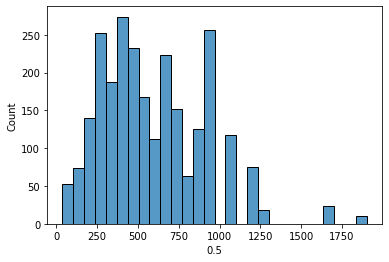

In [ ]:
sns.histplot(x = cph_median[0.5])

In [ ]:
# Find 25 and 75 percentile range of median prob time
cph_median.describe()

,SubjectID,0.5
count,2558.000000,2558.000000
mean,510459.784206,590.405395
std,291454.772392,316.393906
min,329.000000,37.000000
25%,264231.750000,361.000000
50%,517427.500000,519.000000
75%,770337.750000,820.000000
max,999990.000000,1902.000000


In [ ]:
# Categorize into 3 group based on interquartile range
cph_slow_list = list(cph_median[cph_median[0.5] >= 820]['SubjectID'])
cph_intermediate_list = list(cph_median[(cph_median[0.5] >= 361) & (cph_median[0.5] < 820)]['SubjectID'])
cph_rapid_list = list(cph_median[cph_median[0.5]  < 361]['SubjectID'])
X_cph_slow = opt_data[opt_data['SubjectID'].isin(cph_slow_list)]
X_cph_intermediate = opt_data[opt_data['SubjectID'].isin(cph_intermediate_list)]
X_cph_rapid = opt_data[opt_data['SubjectID'].isin(cph_rapid_list)]

In [ ]:
# Create a representative virtual patient with each feature's mean value
VIRT_cph_slow = pd.DataFrame(X_cph_slow.mean()).transpose().iloc[:, 1:-2][finalcox_feature_list]
VIRT_cph_intermediate = pd.DataFrame(X_cph_intermediate.mean()).transpose().iloc[:, 1:-2][finalcox_feature_list]
VIRT_cph_rapid = pd.DataFrame(X_cph_rapid.mean()).transpose().iloc[:, 1:-2][finalcox_feature_list]

In [ ]:
result_cph_slow = cph.predict_survival_function(VIRT_cph_slow)
result_cph_intermediate = cph.predict_survival_function(VIRT_cph_intermediate)
result_cph_rapid = cph.predict_survival_function(VIRT_cph_rapid)

In [ ]:
from lifelines import KaplanMeierFitter
kmf = KaplanMeierFitter()

from lifelines.utils import median_survival_times

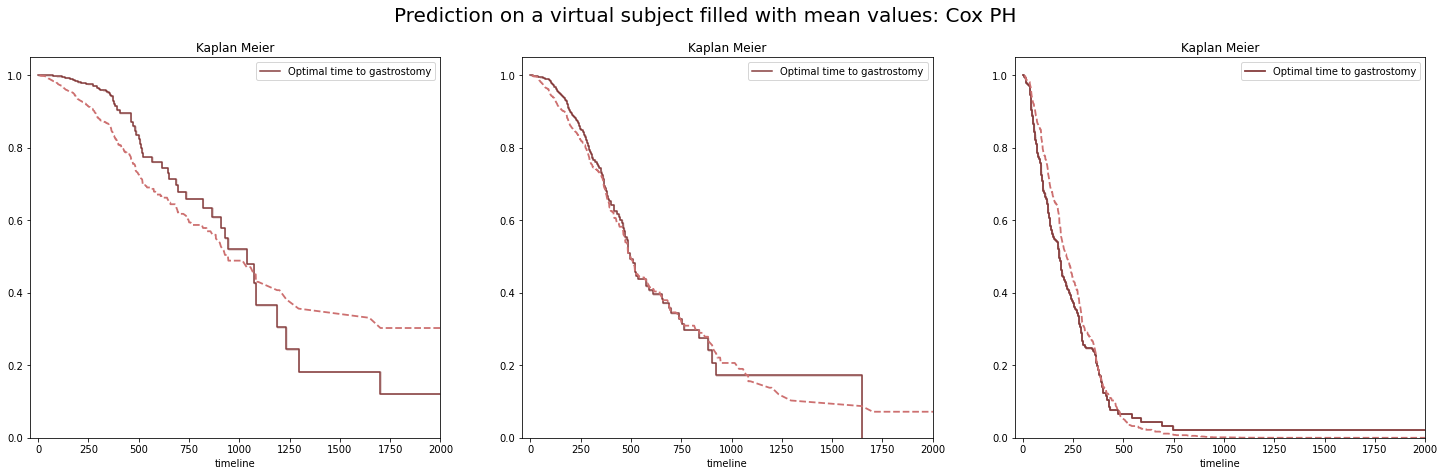

In [ ]:
# Compare KM curve and Cox-prediction curve in each group
# KM in solid lines, pred curve in dotted lines
plt.figure(figsize=(25, 7))

plt.subplot(131)
OPT = kmf.fit(X_cph_slow["time_opt"], X_cph_slow["status_opt"], label='Optimal time to gastrostomy', alpha=1)
ax_kmf = OPT.plot(color='#853C3C', linewidth=1.5)
plt.title("Slow")
plt.plot(result_cph_slow.index, result_cph_slow, marker='None', color='#CD7070', linestyle='--', linewidth=1.8)
plt.xlim([-40,2000])
plt.ylim([0,1.05])


plt.subplot(132)
OPT = kmf.fit(X_cph_intermediate["time_opt"], X_cph_intermediate["status_opt"], label='Optimal time to gastrostomy', alpha=1)
ax_kmf = OPT.plot(color='#853C3C', linewidth=1.5)
plt.title("Intermediate")
plt.plot(result_cph_intermediate.index, result_cph_intermediate, marker='None', color='#CD7070', linestyle='--', linewidth=1.8)
plt.xlim([-40,2000])
plt.ylim([0,1.05])


plt.subplot(133)
OPT = kmf.fit(X_cph_rapid["time_opt"], X_cph_rapid["status_opt"], label='Optimal time to gastrostomy', alpha=1)
ax_kmf = OPT.plot(color='#853C3C', linewidth=1.8)
plt.title("Rapid")
plt.plot(result_cph_rapid.index, result_cph_rapid, marker='None', color='#CD7070', linestyle='--',linewidth=1.8)
plt.xlim([-40,2000])
plt.ylim([0,1.05])

plt.suptitle('Group Stratification: CoxPH', fontsize=20)
plt.show()

## (3) Random Survival Forests model

In [ ]:
def predict_rsf_median(data):
  result = rsf.predict_survival_function(data.to_numpy().reshape(1, -1), return_array = True)
  result = np.squeeze(result)
  time_result = pd.DataFrame({'time' : rsf.event_times_, 'p' : result })

  if time_result[time_result['p'] <= 0.5].count()['time'] == 0:
    median = np.inf
  else:
    median = time_result[time_result['p'] <= 0.5].iloc[0,0]

  return median

In [ ]:
# Extract median probability time
rsf_median_list = []
for i in range(df_train_finalrsf.shape[0]):
  rsf_median_list.append(predict_rsf_median(df_train_finalrsf.iloc[i,:-2]))

rsf_median_list

In [ ]:
subjectID = opt_data['SubjectID'].copy()
subjectID.index = range(len(subjectID))
subjectID

0          329.0
1          708.0
2          902.0
3         1736.0
4         2492.0
          ...   
2553    998756.0
2554    999166.0
2555    999823.0
2556    999880.0
2557    999990.0
Name: SubjectID, Length: 2558, dtype: float64

In [ ]:
rsf_median = pd.concat([subjectID, pd.Series(rsf_median_list)], axis=1)
rsf_median

,SubjectID,0
0,329.0,inf
1,708.0,99.0
2,902.0,903.0
3,1736.0,180.0
4,2492.0,520.0
...,...,...
2553,998756.0,252.0
2554,999166.0,484.0
2555,999823.0,126.0
2556,999880.0,inf


In [ ]:
# Check how many subjects have infinity values on median prob time
print('There are ' + str(rsf_median.replace([np.inf,-np.inf], np.nan).isnull().sum(axis = 0).iloc[1]) + ' inf values in rsf_median')

There are 449 inf values in rsf_median


In [ ]:
# For classification purpose, inf values are replaced to 'max + 200'
rsf_median_max = rsf_median.replace([np.inf,-np.inf], np.nan).dropna(subset=[0],how='all')[0].max()
rsf_inf = rsf_median_max + 200
rsf_median = rsf_median.replace([np.inf,-np.inf], rsf_inf)

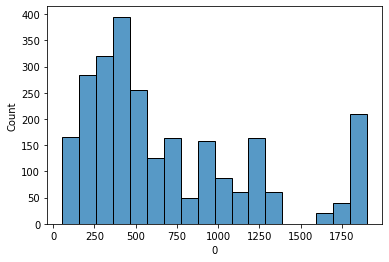

In [ ]:
sns.histplot(x = rsf_median[0])

In [ ]:
# Find 25 and 75 percentile range of median prob time
rsf_median.describe()

,SubjectID,0
count,2558.000000,2558.000000
mean,510459.784206,822.044175
std,291454.772392,627.289694
min,329.000000,48.000000
25%,264231.750000,309.000000
50%,517427.500000,525.000000
75%,770337.750000,1234.000000
max,999990.000000,1902.000000


In [ ]:
# Categorize into 3 group based on interquartile range
rsf_slow_list = list(rsf_median[rsf_median[0] >= 1234]['SubjectID'])
rsf_intermediate_list = list(rsf_median[(rsf_median[0] >= 309) & (rsf_median[0] < 1234)]['SubjectID'])
rsf_rapid_list = list(rsf_median[rsf_median[0]  < 309]['SubjectID'])
X_rsf_slow = opt_data[opt_data['SubjectID'].isin(rsf_slow_list)]
X_rsf_intermediate = opt_data[opt_data['SubjectID'].isin(rsf_intermediate_list)]
X_rsf_rapid = opt_data[opt_data['SubjectID'].isin(rsf_rapid_list)]

In [ ]:
# Create a representative virtual patient with each feature's mean value
VIRT_rsf_slow = pd.DataFrame(X_rsf_slow.mean()).transpose().iloc[:, 1:-2][finalrsf_feature_list]
VIRT_rsf_intermediate = pd.DataFrame(X_rsf_intermediate.mean()).transpose().iloc[:, 1:-2][finalrsf_feature_list]
VIRT_rsf_rapid = pd.DataFrame(X_rsf_rapid.mean()).transpose().iloc[:, 1:-2][finalrsf_feature_list]

In [ ]:
result_rsf_slow = rsf.predict_survival_function(VIRT_rsf_slow, return_array=True)
result_rsf_intermediate = rsf.predict_survival_function(VIRT_rsf_intermediate, return_array=True)
result_rsf_rapid = rsf.predict_survival_function(VIRT_rsf_rapid, return_array=True)

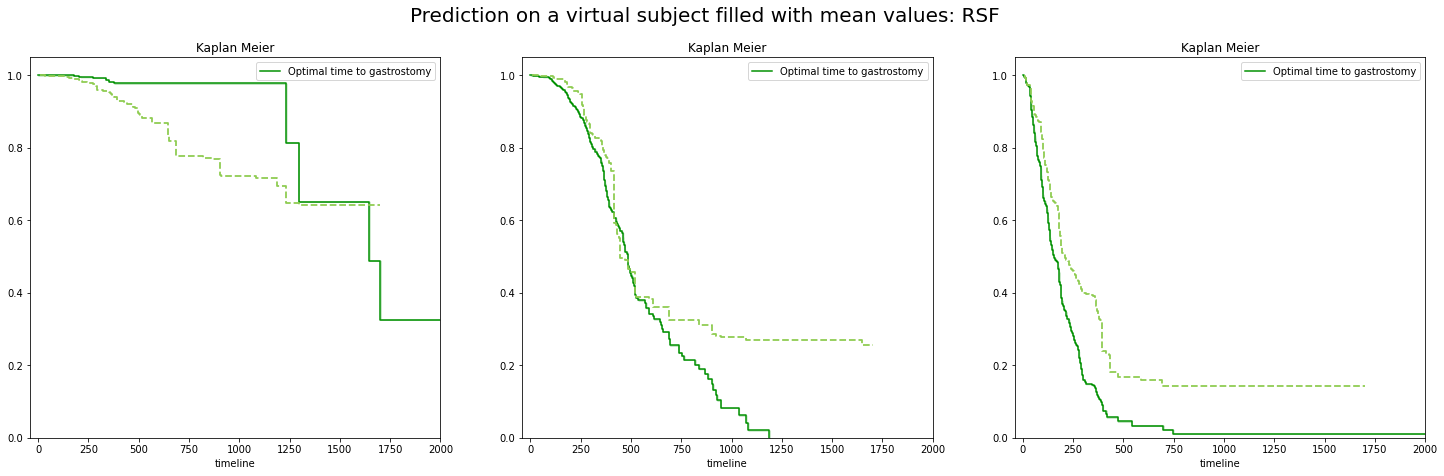

In [ ]:
# Compare KM curve and RSF-prediction curve in each group
# KM in solid lines, pred curve in dotted lines
plt.figure(figsize=(25, 7))

plt.subplot(131)
OPT = kmf.fit(X_rsf_slow["time_opt"], X_rsf_slow["status_opt"], label='Optimal time to gastrostomy', alpha=1)
ax_kmf = OPT.plot(color='#009000', linewidth=1.5)
plt.title("Slow")
for i, s in enumerate(result_rsf_slow):
    plt.step(rsf.event_times_, s, where="post", color='#8FCC52', linestyle='--', linewidth=1.8)
plt.xlim([-40,2000])
plt.ylim([0,1.05])


plt.subplot(132)
OPT = kmf.fit(X_rsf_intermediate["time_opt"], X_rsf_intermediate["status_opt"], label='Optimal time to gastrostomy', alpha=1)
ax_kmf = OPT.plot(color='#009000', linewidth=1.5)
plt.title("Intermediate")
for i, s in enumerate(result_rsf_intermediate):
    plt.step(rsf.event_times_, s, where="post", color='#8FCC52', linestyle='--', linewidth=1.8)
plt.xlim([-40,2000])
plt.ylim([0,1.05])


plt.subplot(133)
OPT = kmf.fit(X_rsf_rapid["time_opt"], X_rsf_rapid["status_opt"], label='Optimal time to gastrostomy', alpha=1)
ax_kmf = OPT.plot(color='#009000', linewidth=1.5)
plt.title("Rapid")
for i, s in enumerate(result_rsf_rapid):
    plt.step(rsf.event_times_, s, where="post", color='#8FCC52', linestyle='--', linewidth=1.8)
plt.xlim([-40,2000])
plt.ylim([0,1.05])

plt.suptitle('Group Stratification: RSF', fontsize=20)
plt.show()

## (4) Comparison

In [ ]:
# Based on group stratification graphs, 25%, 50%, 75% prob time is calculated in each curve
kmf1 = KaplanMeierFitter()
kmf2 = KaplanMeierFitter()
kmf3 = KaplanMeierFitter()
kmf4 = KaplanMeierFitter()
kmf5 = KaplanMeierFitter()
kmf6 = KaplanMeierFitter()
kmf7 = KaplanMeierFitter()
kmf8 = KaplanMeierFitter()
kmf9 = KaplanMeierFitter()


cph_KM_rapid = kmf1.fit(X_cph_fast["time_opt"], X_cph_fast["status_opt"])
cph_KM_intermediate = kmf2.fit(X_cph_medium["time_opt"], X_cph_medium["status_opt"])
cph_KM_slow = kmf3.fit(X_cph_slow["time_opt"], X_cph_slow["status_opt"])

aft_KM_rapid = kmf4.fit(X_aft_fast["time_opt"], X_aft_fast["status_opt"])
aft_KM_intermediate = kmf5.fit(X_aft_medium["time_opt"], X_aft_medium["status_opt"])
aft_KM_slow = kmf6.fit(X_aft_slow["time_opt"], X_aft_slow["status_opt"])

rsf_KM_slow = kmf7.fit(X_rsf_slow["time_opt"], X_rsf_slow["status_opt"])
rsf_KM_intermediate = kmf8.fit(X_rsf_medium["time_opt"], X_rsf_medium["status_opt"])
rsf_KM_rapid = kmf9.fit(X_rsf_fast["time_opt"], X_rsf_fast["status_opt"])

In [ ]:
def predict_rsf_percentile(data, percentile):
  result = rsf.predict_survival_function(data.to_numpy().reshape(1, -1), return_array = True)
  result = np.squeeze(result)
  time_result = pd.DataFrame({'time' : rsf.event_times_, 'p' : result })

  if time_result[time_result['p'] <= percentile].count()['time'] == 0:
    per = np.inf
  else:
    per = time_result[time_result['p'] <= percentile].iloc[0,0]

  return per

In [ ]:
GS_AFT_list = [['KM rapid', aft_KM_rapid.percentile(0.25), aft_KM_rapid.percentile(0.5), aft_KM_rapid.percentile(0.75)],
               ['Aft rapid', aft.predict_percentile(df=VIRT_aft_fast, ancillary=None, p=0.25)[0], aft.predict_median(VIRT_aft_fast)[0], aft.predict_percentile(df=VIRT_aft_fast, ancillary=None, p=0.75)[0]],
               ['KM intermediate', aft_KM_intermediate.percentile(0.25), aft_KM_intermediate.percentile(0.5), aft_KM_intermediate.percentile(0.75)],
               ['Aft intermediate', aft.predict_percentile(df=VIRT_aft_medium, ancillary=None, p=0.25)[0], aft.predict_median(VIRT_aft_medium)[0], aft.predict_percentile(df=VIRT_aft_medium, ancillary=None, p=0.75)[0]],
               ['KM slow', aft_KM_slow.percentile(0.25), aft_KM_slow.percentile(0.5), aft_KM_slow.percentile(0.75)],
               ['Aft slow', aft.predict_percentile(VIRT_aft_slow, ancillary=None, p=0.25)[0], aft.predict_median(VIRT_aft_slow)[0], aft.predict_percentile(VIRT_aft_slow, ancillary=None, p=0.75)[0]]]

GS_COX_list = [['KM rapid', cph_KM_rapid.percentile(0.25), cph_KM_rapid.percentile(0.5), cph_KM_rapid.percentile(0.75)],
               ['Cox rapid', cph.predict_percentile(VIRT_cph_fast, 0.25), cph.predict_median(VIRT_cph_fast), cph.predict_percentile(VIRT_cph_fast, 0.75)],
               ['KM intermediate', cph_KM_intermediate.percentile(0.25), cph_KM_intermediate.percentile(0.5), cph_KM_intermediate.percentile(0.75)],
               ['Cox intermediate', cph.predict_percentile(VIRT_cph_medium, 0.25), cph.predict_median(VIRT_cph_medium), cph.predict_percentile(VIRT_cph_medium, 0.75)],
               ['KM slow', cph_KM_slow.percentile(0.25), cph_KM_slow.percentile(0.5), cph_KM_slow.percentile(0.75)],
               ['Cox slow', cph.predict_percentile(VIRT_cph_slow, 0.25), cph.predict_median(VIRT_cph_slow), cph.predict_percentile(VIRT_cph_slow, 0.75)]]

GS_RSF_list = [['KM rapid', rsf_KM_rapid.percentile(0.25), rsf_KM_rapid.percentile(0.5), rsf_KM_rapid.percentile(0.75)],
               ['Rsf rapid', predict_rsf_percentile(VIRT_rsf_fast, 0.25), predict_rsf_percentile(VIRT_rsf_fast, 0.5), predict_rsf_percentile(VIRT_rsf_fast, 0.75)],
               ['KM intermediate', rsf_KM_intermediate.percentile(0.25), rsf_KM_intermediate.percentile(0.5), rsf_KM_intermediate.percentile(0.75)],
               ['Rsf intermediate', predict_rsf_percentile(VIRT_rsf_medium, 0.25), predict_rsf_percentile(VIRT_rsf_medium, 0.5), predict_rsf_percentile(VIRT_rsf_medium, 0.75)],
               ['KM slow', rsf_KM_slow.percentile(0.25), rsf_KM_slow.percentile(0.5), rsf_KM_slow.percentile(0.75)],
               ['Rsf slow', predict_rsf_percentile(VIRT_rsf_slow, 0.25), predict_rsf_percentile(VIRT_rsf_slow, 0.5), predict_rsf_percentile(VIRT_rsf_slow, 0.75)]]

GS_AFT = pd.DataFrame(GS_AFT_list,columns=['model','25%','50%','75%'])
GS_COX = pd.DataFrame(GS_COX_list,columns=['model','25%','50%','75%'])
GS_RSF = pd.DataFrame(GS_RSF_list,columns=['model','25%','50%','75%'])

In [ ]:
GS_AFT

,model,25%,50%,75%
0,KM rapid,344.000000,182.000000,91.000000
1,Aft rapid,353.848221,221.527878,122.290296
2,KM intermediate,884.000000,495.000000,336.000000
3,Aft intermediate,894.407155,559.946630,309.108001
4,KM slow,1295.000000,1037.000000,649.000000
5,Aft slow,1487.609145,931.322746,514.119197


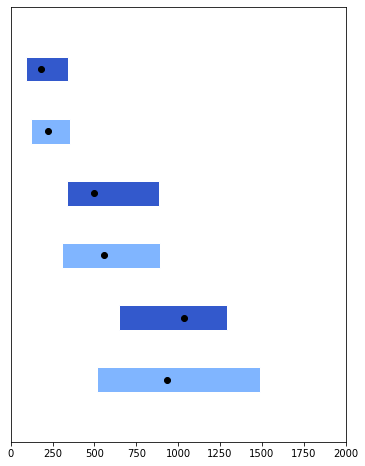

In [ ]:
# Thick colored lines represent the interquartile range time to event
# Black dots in the middle represent median probability time to event
import matplotlib as mp
fig, ax = plt.subplots(figsize=(6,8))

plt.xlim([0,2000])
plt.ylim([0,7])
rect1 = mp.patches.Rectangle((GS_AFT.iloc[0,3],5.8), (GS_AFT.iloc[0,1]-GS_AFT.iloc[0,3]), 0.4, edgecolor='white', facecolor='#3359CC')
rect2 = mp.patches.Rectangle((GS_AFT.iloc[1,3],4.8), (GS_AFT.iloc[1,1]-GS_AFT.iloc[1,3]), 0.4, edgecolor='white', facecolor='#80b5ff')
rect3 = mp.patches.Rectangle((GS_AFT.iloc[2,3],3.8), (GS_AFT.iloc[2,1]-GS_AFT.iloc[2,3]), 0.4, edgecolor='white', facecolor='#3359CC')
rect4 = mp.patches.Rectangle((GS_AFT.iloc[3,3],2.8), (GS_AFT.iloc[3,1]-GS_AFT.iloc[3,3]), 0.4, edgecolor='white', facecolor='#80b5ff')
rect5 = mp.patches.Rectangle((GS_AFT.iloc[4,3],1.8), (GS_AFT.iloc[4,1]-GS_AFT.iloc[4,3]), 0.4, edgecolor='white', facecolor='#3359CC')
rect6 = mp.patches.Rectangle((GS_AFT.iloc[5,3],0.8), (GS_AFT.iloc[5,1]-GS_AFT.iloc[5,3]), 0.4, edgecolor='white', facecolor='#80b5ff')
plt.plot(GS_AFT.iloc[0,2],6,'ko')
plt.plot(GS_AFT.iloc[1,2],5,'ko')
plt.plot(GS_AFT.iloc[2,2],4,'ko')
plt.plot(GS_AFT.iloc[3,2],3,'ko')
plt.plot(GS_AFT.iloc[4,2],2,'ko')
plt.plot(GS_AFT.iloc[5,2],1,'ko')

ax.yaxis.set_visible(False)
ax.add_patch(rect1)
ax.add_patch(rect2)
ax.add_patch(rect3)
ax.add_patch(rect4)
ax.add_patch(rect5)
ax.add_patch(rect6)

In [ ]:
GS_COX

,model,25%,50%,75%
0,KM rapid,309.0,182.0,91.0
1,Cox rapid,355.0,219.0,122.0
2,KM intermediate,884.0,497.0,338.0
3,Cox intermediate,909.0,497.0,308.0
4,KM slow,1234.0,1037.0,614.0
5,Cox slow,inf,946.0,483.0


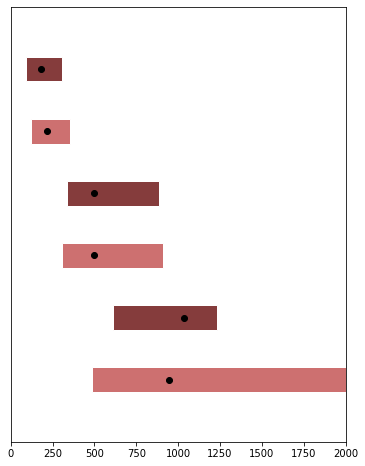

In [ ]:
# Thick colored lines represent the interquartile range time to event
# Black dots in the middle represent median probability time to event
fig, ax = plt.subplots(figsize=(6,8))

plt.xlim([0,2000])
plt.ylim([0,7])
rect1 = mp.patches.Rectangle((GS_COX.iloc[0,3],5.8), (GS_COX.iloc[0,1]-GS_COX.iloc[0,3]), 0.4, edgecolor='white', facecolor='#853C3C')
rect2 = mp.patches.Rectangle((GS_COX.iloc[1,3],4.8), (GS_COX.iloc[1,1]-GS_COX.iloc[1,3]), 0.4, edgecolor='white', facecolor='#CD7070')
rect3 = mp.patches.Rectangle((GS_COX.iloc[2,3],3.8), (GS_COX.iloc[2,1]-GS_COX.iloc[2,3]), 0.4, edgecolor='white', facecolor='#853C3C')
rect4 = mp.patches.Rectangle((GS_COX.iloc[3,3],2.8), (GS_COX.iloc[3,1]-GS_COX.iloc[3,3]), 0.4, edgecolor='white', facecolor='#CD7070')
rect5 = mp.patches.Rectangle((GS_COX.iloc[4,3],1.8), (GS_COX.iloc[4,1]-GS_COX.iloc[4,3]), 0.4, edgecolor='white', facecolor='#853C3C')
rect6 = mp.patches.Rectangle((GS_COX.iloc[5,3],0.8), 2000, 0.4, edgecolor='white', facecolor='#CD7070')
plt.plot(GS_COX.iloc[0,2],6,'ko')
plt.plot(GS_COX.iloc[1,2],5,'ko')
plt.plot(GS_COX.iloc[2,2],4,'ko')
plt.plot(GS_COX.iloc[3,2],3,'ko')
plt.plot(GS_COX.iloc[4,2],2,'ko')
plt.plot(GS_COX.iloc[5,2],1,'ko')

ax.yaxis.set_visible(False)
ax.add_patch(rect1)
ax.add_patch(rect2)
ax.add_patch(rect3)
ax.add_patch(rect4)
ax.add_patch(rect5)
ax.add_patch(rect6)

In [ ]:
GS_RSF

,model,25%,50%,75%
0,KM rapid,281.0,174.0,89.0
1,Rsf rapid,416.0,212.0,112.0
2,KM intermediate,751.0,484.0,355.0
3,Rsf intermediate,inf,502.0,413.0
4,KM slow,1702.0,1234.0,1073.0
5,Rsf slow,inf,inf,1188.0


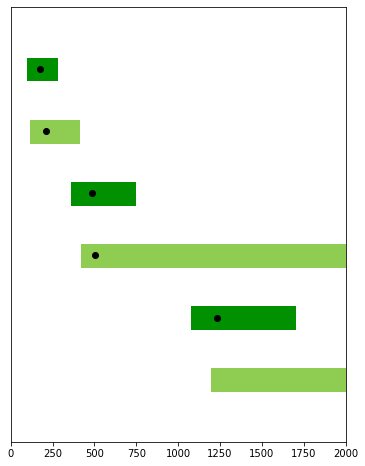

In [ ]:
# Thick colored lines represent the interquartile range time to event
# Black dots in the middle represent median probability time to event
fig, ax = plt.subplots(figsize=(6,8))

plt.xlim([0,2000])
plt.ylim([0,7])
rect1 = mp.patches.Rectangle((GS_RSF.iloc[0,3],5.8), (GS_RSF.iloc[0,1]-GS_RSF.iloc[0,3]), 0.4, edgecolor='white', facecolor='#009000')
rect2 = mp.patches.Rectangle((GS_RSF.iloc[1,3],4.8), (GS_RSF.iloc[1,1]-GS_RSF.iloc[1,3]), 0.4, edgecolor='white', facecolor='#8FCC52')
rect3 = mp.patches.Rectangle((GS_RSF.iloc[2,3],3.8), (GS_RSF.iloc[2,1]-GS_RSF.iloc[2,3]), 0.4, edgecolor='white', facecolor='#009000')
rect4 = mp.patches.Rectangle((GS_RSF.iloc[3,3],2.8), 2000, 0.4, edgecolor='white', facecolor='#8FCC52')
rect5 = mp.patches.Rectangle((GS_RSF.iloc[4,3],1.8), (GS_RSF.iloc[4,1]-GS_RSF.iloc[4,3]), 0.4, edgecolor='white', facecolor='#009000')
rect6 = mp.patches.Rectangle((GS_RSF.iloc[5,3],0.8), 2000, 0.4, edgecolor='white', facecolor='#8FCC52')
plt.plot(GS_RSF.iloc[0,2],6,'ko')
plt.plot(GS_RSF.iloc[1,2],5,'ko')
plt.plot(GS_RSF.iloc[2,2],4,'ko')
plt.plot(GS_RSF.iloc[3,2],3,'ko')
plt.plot(GS_RSF.iloc[4,2],2,'ko')

ax.yaxis.set_visible(False)
ax.add_patch(rect1)
ax.add_patch(rect2)
ax.add_patch(rect3)
ax.add_patch(rect4)
ax.add_patch(rect5)
ax.add_patch(rect6)